# Sheet 5

In [1]:
import os
import pandas as pd

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [2]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [3]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

### (a)

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
def train_log_reg(X,y,penalty=None,tol=1e-4): # training- data, labels    
    clf = LogisticRegression(penalty=penalty,tol=tol)
    clf.fit(X, y)

    return clf

def test_log_reg(clf, X, y): # test- data, labels
    #clf.predict(X)
    return clf.score(X,y)

In [6]:
for i in range(len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} performance :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    acts_test, labels_test = dm.get('val')

    clf = train_log_reg(acts_train, labels_train)
    score_clf = test_log_reg(clf,acts_test, labels_test)
    print(f"score: {score_clf}")

cities performance :
score: 0.9966666666666667
neg_cities performance :
score: 1.0
sp_en_trans performance :
score: 1.0
neg_sp_en_trans performance :
score: 1.0


### (b)

In [7]:
# train on cities w. and wo. regularization: 
dm = DataManager()
dm.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')

cities_clf = train_log_reg(acts_train, labels_train)
cities_clf_regularization = train_log_reg(acts_train, labels_train,penalty='l2')

In [8]:
print("Cities classifier performance on out of distribution test sets:")
for i in range(1,len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')

    score_cities_clf = test_log_reg(cities_clf,acts_test, labels_test)
    print(f"score unregularized: {score_cities_clf}")
    score_cities_clf_reg = test_log_reg(cities_clf_regularization,acts_test, labels_test)
    print(f"score regularized: {score_cities_clf_reg}")

Cities classifier performance on out of distribution test sets:
neg_cities :
score unregularized: 0.51
score regularized: 0.51
sp_en_trans :
score unregularized: 0.8873239436619719
score regularized: 1.0
neg_sp_en_trans :
score unregularized: 0.5070422535211268
score regularized: 0.5070422535211268


### (c)

In [9]:
import torch as t

In [10]:
# loading both data sets
dm = DataManager()
dm.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')

dm = DataManager()
dm.add_dataset("neg_cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train_neg, labels_train_neg = dm.get('train') # train set
acts_test_neg, labels_test_neg = dm.get('val')

# adding the data sets together:
train_data = t.cat((acts_train, acts_train_neg), dim=0)
train_labels = t.cat((labels_train, labels_train_neg), dim=0)
test_data = t.cat((acts_test, acts_test_neg), dim=0)
test_labels = t.cat((labels_test, labels_test_neg), dim=0)

# shuffeling data and train data
indices_tr = t.randperm(len(train_labels))
indices_te = t.randperm(len(test_labels))

train_data = train_data[indices_tr]
train_labels = train_labels[indices_tr]
test_data = train_data[indices_te]
test_labels = train_labels[indices_te]

In [11]:
cities_cities_neg_clf = train_log_reg(train_data, train_labels)
cities_cities_neg_clf_regularization = train_log_reg(train_data, train_labels,penalty='l2')

In [12]:
print("Cities and negation citites classifier performance on out of distribution test sets:")
for i in range(2,len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')

    score_cities_cities_neg_clf = test_log_reg(cities_cities_neg_clf,acts_test, labels_test)
    print(f"score unregularized: {score_cities_cities_neg_clf}")
    score_cities_cities_neg_reg = test_log_reg(cities_clf_regularization,acts_test, labels_test)
    print(f"score regularized: {score_cities_cities_neg_reg}")

Cities and negation citites classifier performance on out of distribution test sets:
sp_en_trans :
score unregularized: 1.0
score regularized: 0.9859154929577465
neg_sp_en_trans :
score unregularized: 0.9154929577464789
score regularized: 0.5070422535211268


## 3 Log-sum-exp and soft(arg)max
### (b)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def lse(sigma1, sigma2, lam):
    return (1 / lam) * np.log(np.exp(lam * sigma1) + np.exp(lam * sigma2))

def max_func(sigma1, sigma2):
    return np.maximum(sigma1, sigma2)

def softmax_sigma1(sigma1, sigma2, lam):
    exp_sigma1 = np.exp(lam * sigma1)
    exp_sigma2 = np.exp(lam * sigma2)
    return exp_sigma1 / (exp_sigma1 + exp_sigma2)

def softmax_sigma2(sigma1, sigma2, lam):
    exp_sigma1 = np.exp(lam * sigma1)
    exp_sigma2 = np.exp(lam * sigma2)
    return exp_sigma2 / (exp_sigma1 + exp_sigma2)

def one_hot_argmax(sigma1, sigma2):
    return np.where(sigma1 > sigma2, np.array([1, 0]), np.array([0, 1]))


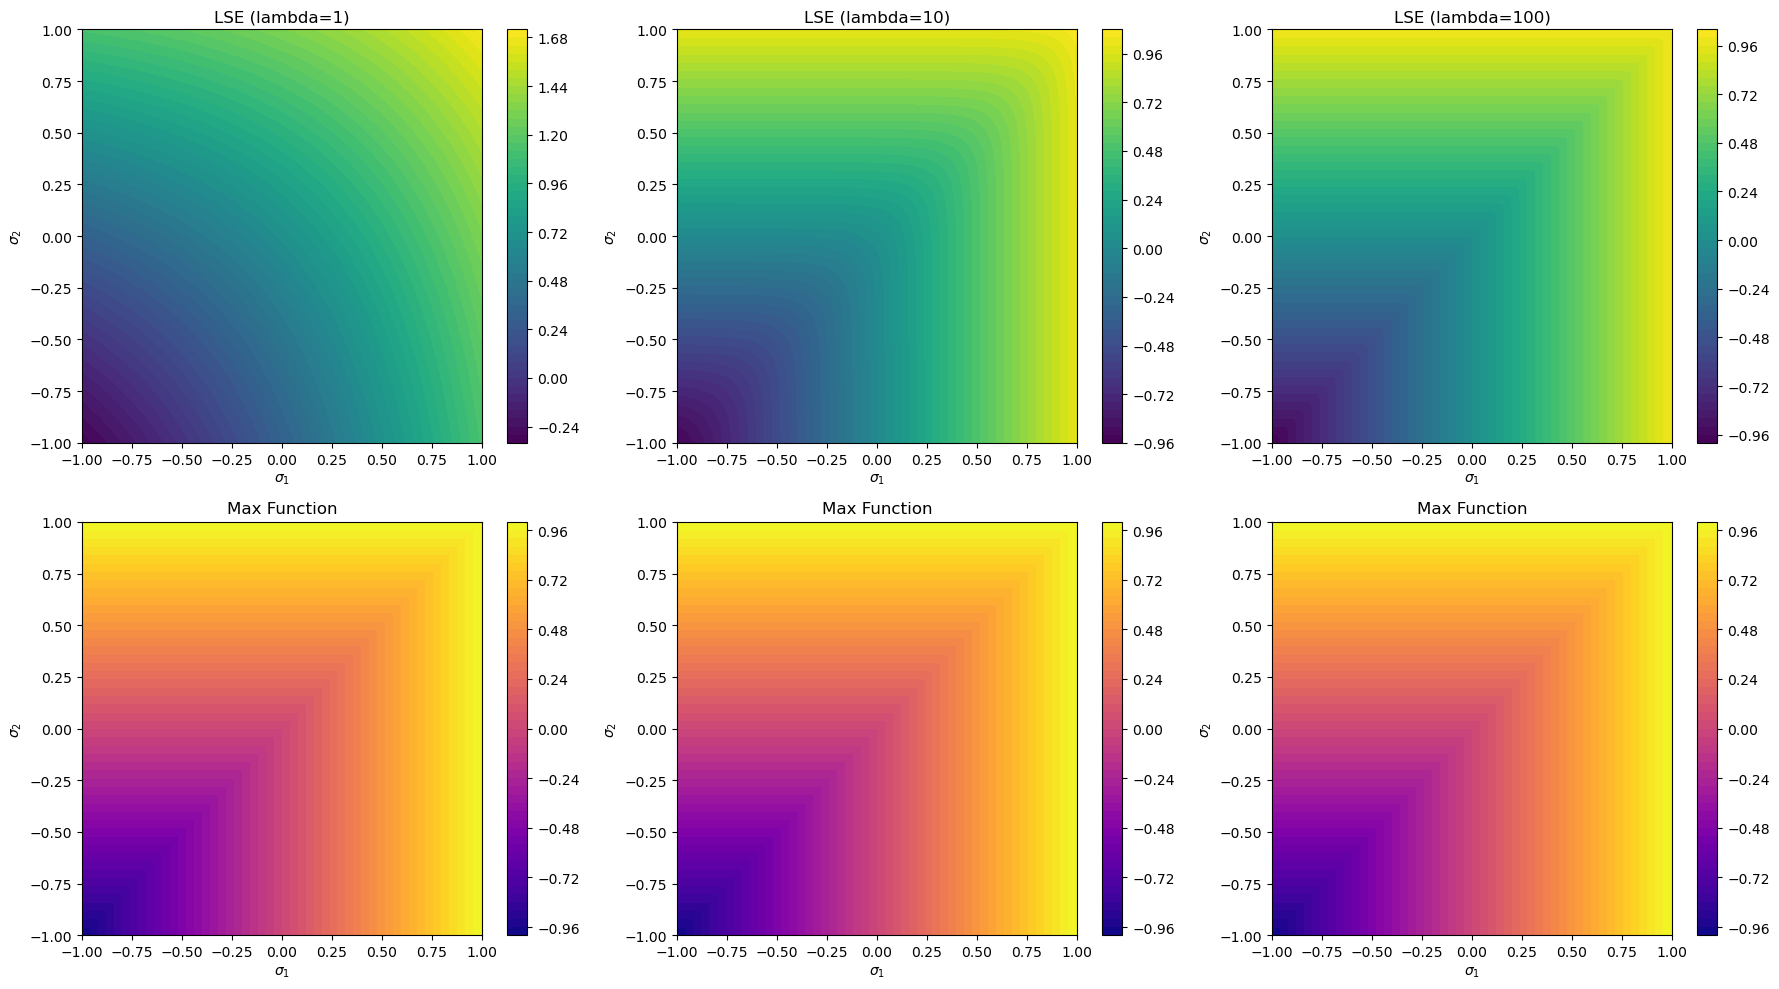

In [15]:
sigma1 = sigma2 = np.linspace(-1, 1, 500)
S1, S2 = np.meshgrid(sigma1, sigma2)

# Lambda values
lambdas = [1, 10, 100]

# Create subplots
fig, axs = plt.subplots(2, len(lambdas), figsize=(18, 10))

# Generate contour plots for LSE with different lambda values
for i, lam in enumerate(lambdas):
    LSE_values = lse(S1, S2, lam)
    contour = axs[0, i].contourf(S1, S2, LSE_values, levels=50, cmap='viridis')
    axs[0, i].set_title(f"LSE (lambda={lam})")
    axs[0, i].set_xlabel(r"$\sigma_1$")
    axs[0, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(contour, ax=axs[0, i])

# Generate contour plot for max function
max_values = max_func(S1, S2)
for i in range(len(lambdas)):
    contour = axs[1, i].contourf(S1, S2, max_values, levels=50, cmap='plasma')
    axs[1, i].set_title("Max Function")
    axs[1, i].set_xlabel(r"$\sigma_1$")
    axs[1, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(contour, ax=axs[1, i])

plt.tight_layout()
plt.show()

### (c)

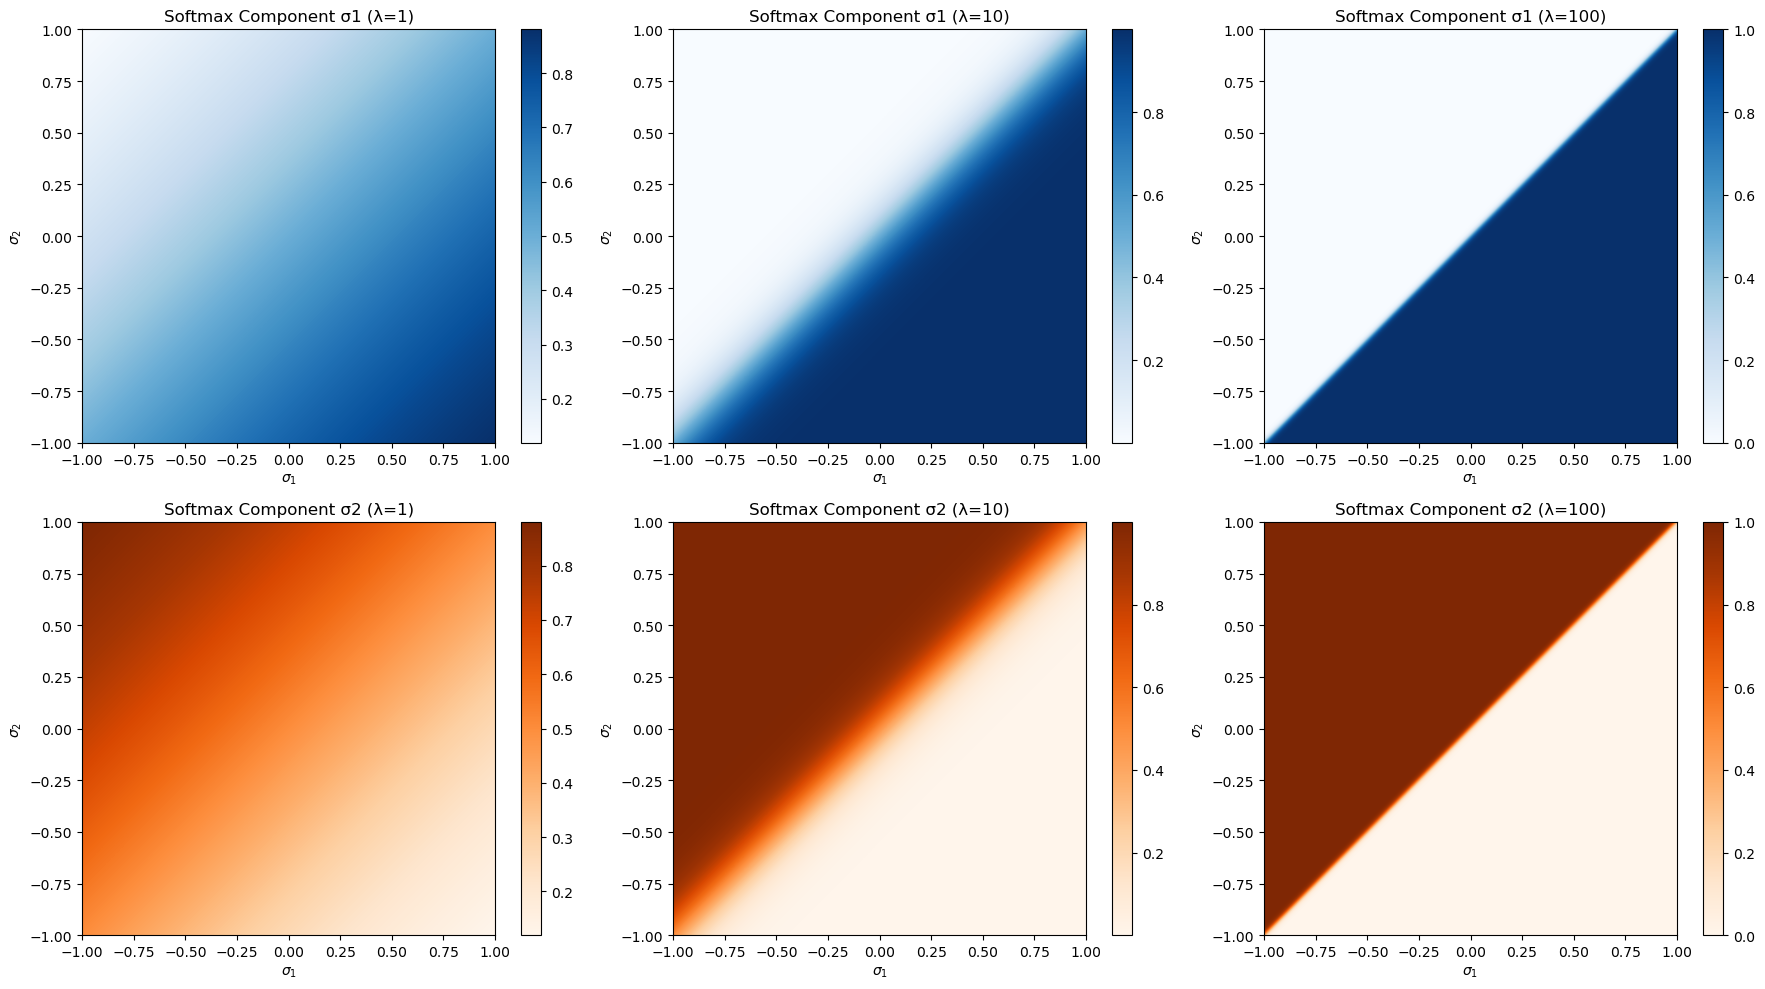

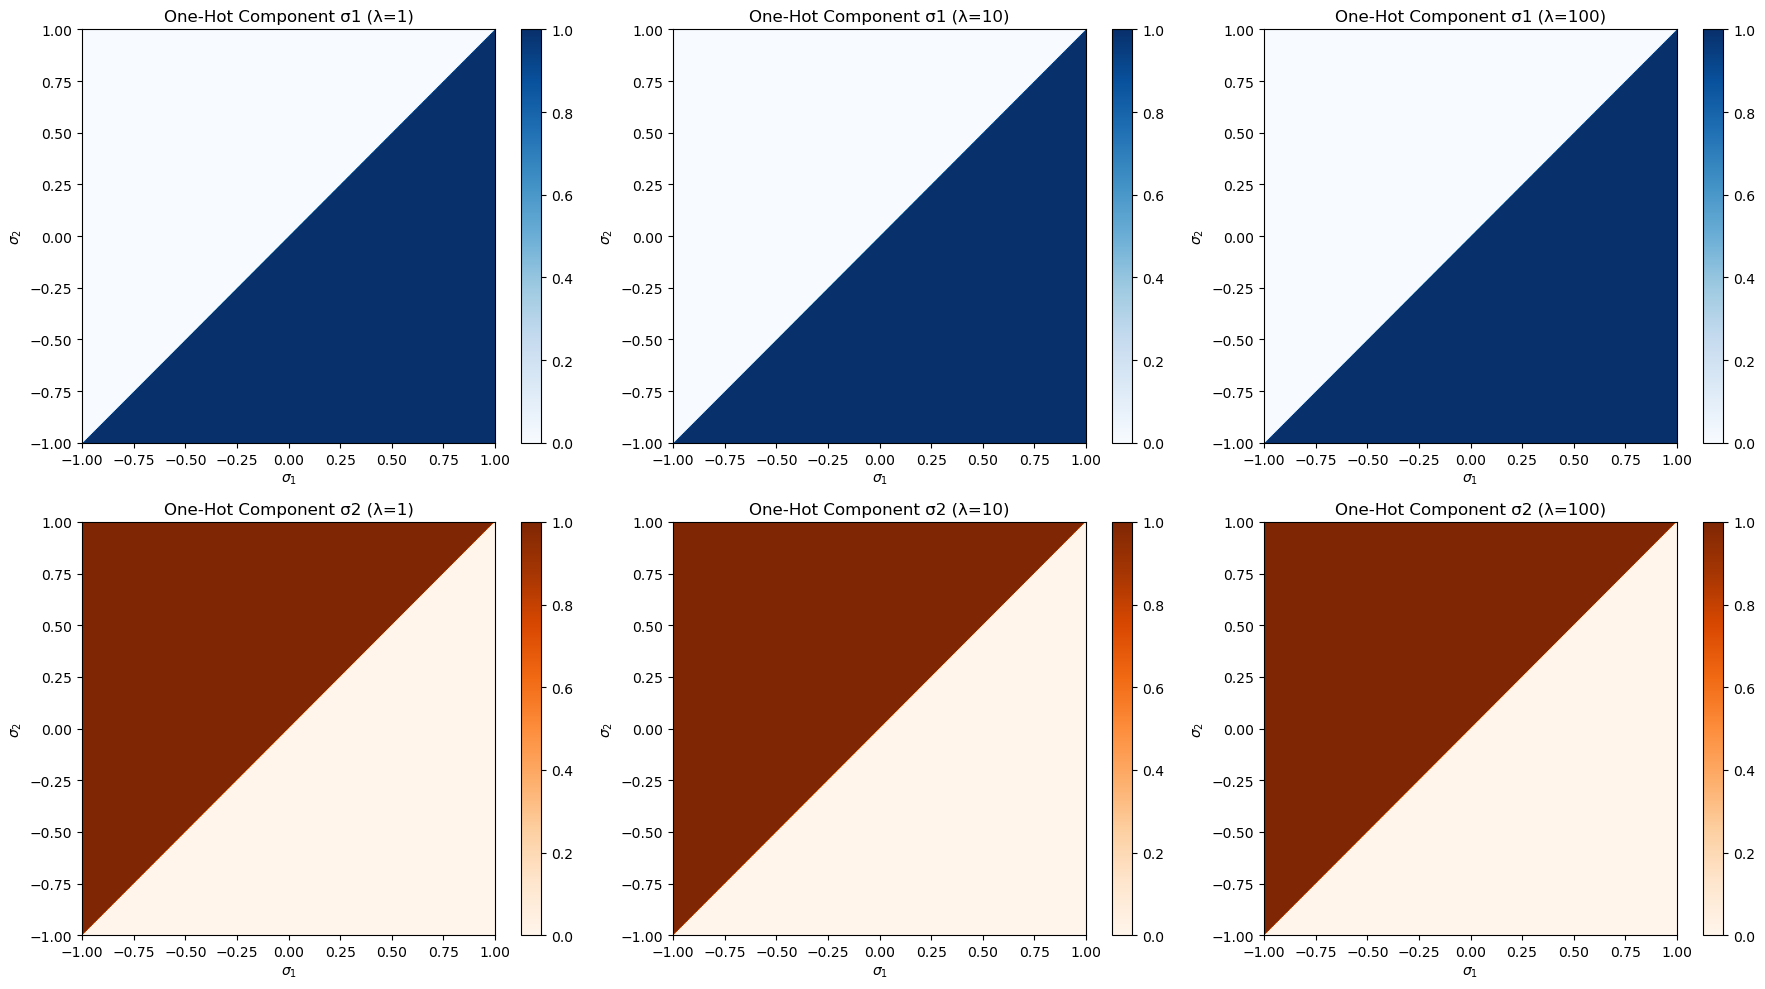

In [16]:
# Create subplots
fig, axs = plt.subplots(2, len(lambdas), figsize=(18, 10))

# Generate softmax component plots for σ1 and σ2
for i, lam in enumerate(lambdas):
    softmax1_values = softmax_sigma1(S1, S2, lam)
    softmax2_values = softmax_sigma2(S1, S2, lam)
    
    # Plot softmax component for σ1
    im1 = axs[0, i].imshow(softmax1_values, extent=(-1, 1, -1, 1), origin='lower', aspect='auto', cmap='Blues')
    axs[0, i].set_title(f"Softmax Component σ1 (λ={lam})")
    axs[0, i].set_xlabel(r"$\sigma_1$")
    axs[0, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(im1, ax=axs[0, i])

    # Plot softmax component for σ2
    im2 = axs[1, i].imshow(softmax2_values, extent=(-1, 1, -1, 1), origin='lower', aspect='auto', cmap='Oranges')
    axs[1, i].set_title(f"Softmax Component σ2 (λ={lam})")
    axs[1, i].set_xlabel(r"$\sigma_1$")
    axs[1, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(im2, ax=axs[1, i])

plt.tight_layout()
plt.show()

# Now plot one-hot encoding of argmax for σ1 and σ2
fig, axs = plt.subplots(2, len(lambdas), figsize=(18, 10))

for i, lam in enumerate(lambdas):
    # Get one-hot encoded values
    one_hot_values = np.array([one_hot_argmax(s1, s2) for s1, s2 in zip(S1.flatten(), S2.flatten())])
    one_hot_values = one_hot_values.reshape(S1.shape[0], S1.shape[1], 2)
    
    # Plot one-hot component for σ1
    im3 = axs[0, i].imshow(one_hot_values[:, :, 0], extent=(-1, 1, -1, 1), origin='lower', aspect='auto', cmap='Blues')
    axs[0, i].set_title(f"One-Hot Component σ1 (λ={lam})")
    axs[0, i].set_xlabel(r"$\sigma_1$")
    axs[0, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(im3, ax=axs[0, i])

    # Plot one-hot component for σ2
    im4 = axs[1, i].imshow(one_hot_values[:, :, 1], extent=(-1, 1, -1, 1), origin='lower', aspect='auto', cmap='Oranges')
    axs[1, i].set_title(f"One-Hot Component σ2 (λ={lam})")
    axs[1, i].set_xlabel(r"$\sigma_1$")
    axs[1, i].set_ylabel(r"$\sigma_2$")
    fig.colorbar(im4, ax=axs[1, i])

plt.tight_layout()
plt.show()

## 4 Linear regions of MLPs